## Concrete Compressive Strength

Concrete is the most important material in civil engineering. The concrete compressive strength is a highly nonlinear function of age and ingredients. These ingredients include cement, blast furnace slag, fly ash,  water, superplasticizer, coarse aggregate, and fine aggregate.

The actual concrete compressive strength (MPa) for a given mixture under a specific age (days) was determined from laboratory. Data is in raw form (not scaled).


### Variable Information:

Given is the variable name, variable type, the measurement unit and a brief description. 
The concrete compressive strength is the regression problem. The order of this listing corresponds to the order of numerals along the rows of the database. 

Name -- Data Type -- Measurement -- Description

- Cement (component 1) -- quantitative -- kg in a m3 mixture -- Input Variable
- Blast Furnace Slag (component 2) -- quantitative -- kg in a m3 mixture -- Input Variable
- Fly Ash (component 3) -- quantitative -- kg in a m3 mixture -- Input Variable
- Water (component 4) -- quantitative -- kg in a m3 mixture -- Input Variable
- Superplasticizer (component 5) -- quantitative -- kg in a m3 mixture -- Input Variable
- Coarse Aggregate (component 6) -- quantitative -- kg in a m3 mixture -- Input Variable
- Fine Aggregate (component 7) -- quantitative -- kg in a m3 mixture -- Input Variable
- Age -- quantitative -- Day (1~365) -- Input Variable (Concrete hardens with time and strength increases. Usually, concrete is tested after 28 days.)
- Concrete compressive strength -- quantitative -- MPa -- Output Variable 


### Let's frame the problem: 
    - It is clearly a typical supervised learning task since you are given labeled training examples (each instance comes with the expected output, i.e., the Concrete compressive strength ). 
    - It is also a typical regression task, since you are asked to predict a value. More specifically, this is a multivariate regression problem since the system will use multiple features to make a prediction
    

### Select a Performance Measure

Next step is to select a performance measure. A typical performance measure for regression problems is the Root Mean Square Error (RMSE). It gives an idea of how much error the system typically makes in its predictions, with a higher weight for large errors.

### Import necessary modules

In [1]:
#Import all the necessary modules
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (10,8)


import warnings
warnings.filterwarnings('ignore')

#!jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10

from scipy.stats import zscore
from sklearn.decomposition import PCA


from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_nodeinteractivity = 'all'


from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
import xgboost 

### Load the Data

In [2]:
df = pd.read_csv("concrete_1.csv")

### Take a Quick Look at the Data Structure

In [3]:
df.head()

cement   slag    ash  water  superplastic  coarseagg  fineagg  age  \
0   141.3  212.0    0.0  203.5           0.0      971.8    748.5   28   
1   168.9   42.2  124.3  158.3          10.8     1080.8    796.2   14   
2   250.0    0.0   95.7  187.4           5.5      956.9    861.2   28   
3   266.0  114.0    0.0  228.0           0.0      932.0    670.0   28   
4   154.8  183.4    0.0  193.3           9.1     1047.4    696.7   28   

   strength  
0     29.89  
1     23.51  
2     29.22  
3     45.85  
4     18.29

In [4]:
#The info() method is useful to get a quick description of the data, in particular the total number of rows, and each attribute’s type and number of non-null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
cement          1030 non-null float64
slag            1030 non-null float64
ash             1030 non-null float64
water           1030 non-null float64
superplastic    1030 non-null float64
coarseagg       1030 non-null float64
fineagg         1030 non-null float64
age             1030 non-null int64
strength        1030 non-null float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


In [5]:
#The describe() method shows a summary of the numerical attributes
df.describe().T

count        mean         std     min      25%      50%  \
cement        1030.0  281.167864  104.506364  102.00  192.375  272.900   
slag          1030.0   73.895825   86.279342    0.00    0.000   22.000   
ash           1030.0   54.188350   63.997004    0.00    0.000    0.000   
water         1030.0  181.567282   21.354219  121.80  164.900  185.000   
superplastic  1030.0    6.204660    5.973841    0.00    0.000    6.400   
coarseagg     1030.0  972.918932   77.753954  801.00  932.000  968.000   
fineagg       1030.0  773.580485   80.175980  594.00  730.950  779.500   
age           1030.0   45.662136   63.169912    1.00    7.000   28.000   
strength      1030.0   35.817961   16.705742    2.33   23.710   34.445   

                   75%     max  
cement         350.000   540.0  
slag           142.950   359.4  
ash            118.300   200.1  
water          192.000   247.0  
superplastic    10.200    32.2  
coarseagg     1029.400  1145.0  
fineagg        824.000   992.6  
age             56.000   365.0  
strength        46.135    82.6

In [6]:
def basic_details(df):
    b = pd.DataFrame()
    b['Missing value'] = df.isnull().sum()
    b['N unique value'] = df.nunique()
    b['dtype'] = df.dtypes
    return b
basic_details(df)

Missing value  N unique value    dtype
cement                    0             278  float64
slag                      0             185  float64
ash                       0             156  float64
water                     0             195  float64
superplastic              0             111  float64
coarseagg                 0             284  float64
fineagg                   0             302  float64
age                       0              14    int64
strength                  0             845  float64

### Observations
- There are 9 columns and 1030 rows
- There are no missing values in this dataset. However, slag, ash and superplastic columns have minimum values as zero's, need to check if they indicate missing values 
- All the columns are numeric columns, there are no categorical columns in this dataset
- The std row shows the standard deviation, which measures how dispersed the values are
- The 25%, 50%, and 75% rows show the corresponding percentiles: a percentile indicates the value below which a given percentage of observations in a group of observations falls. 
  For example, 25% of the observation have water component lower than 164, while 50% have water compoenent lower than 185 and 75% have water compoenent lower than 192. These are often called the 25th percentile (or 1st quartile), the median, and the 75th percentile (or 3rd quartile).

In [7]:
target = 'strength'
X = df.loc[:, df.columns!=target]
y = df.loc[:, df.columns==target]

### Split the data into train and test 

While spliting the data, we may want to ensure that the test set is representative of the various categories of strength in the whole dataset. Since the strength is a continuous numerical attribute,  we will have to trick Python into interpreting your continuous numerical y variable as a categorical variable instead. By creating bins, and passing  y variable into an ndarray containing those bins and the corresponding values.

In [8]:
# Create the bins.  My `y` variable has 1030 observations, and I want 50 bins.

bins = np.linspace(0, df.shape[0], 50)

# Save your Y values in a new ndarray,
# broken down by the bins created above.

y_binned = np.digitize(y, bins)

# Pass y_binned to the stratify argument,
# and sklearn will handle the rest

#Test train split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y_binned,random_state=2)

### Feature Selection Using Random Forest

### Discover and Visualize the Data to Gain Insights
We have taken a  quick glance at the data to get a general understanding of the kind of data. Now the goal is to go a little bit more in depth.
First, we will make sure we have put the test set aside and we are only exploring the training set. Also, if the
training set is very large, we may want to sample an exploration set, to make manipulations easy and fast.
In our case, the set is quite small so we can just work directly on the full set.

In [9]:
df_temp = pd.concat([X_train,y_train],axis=1)

### Lets look at the distribution plot (Univariate Analysis)

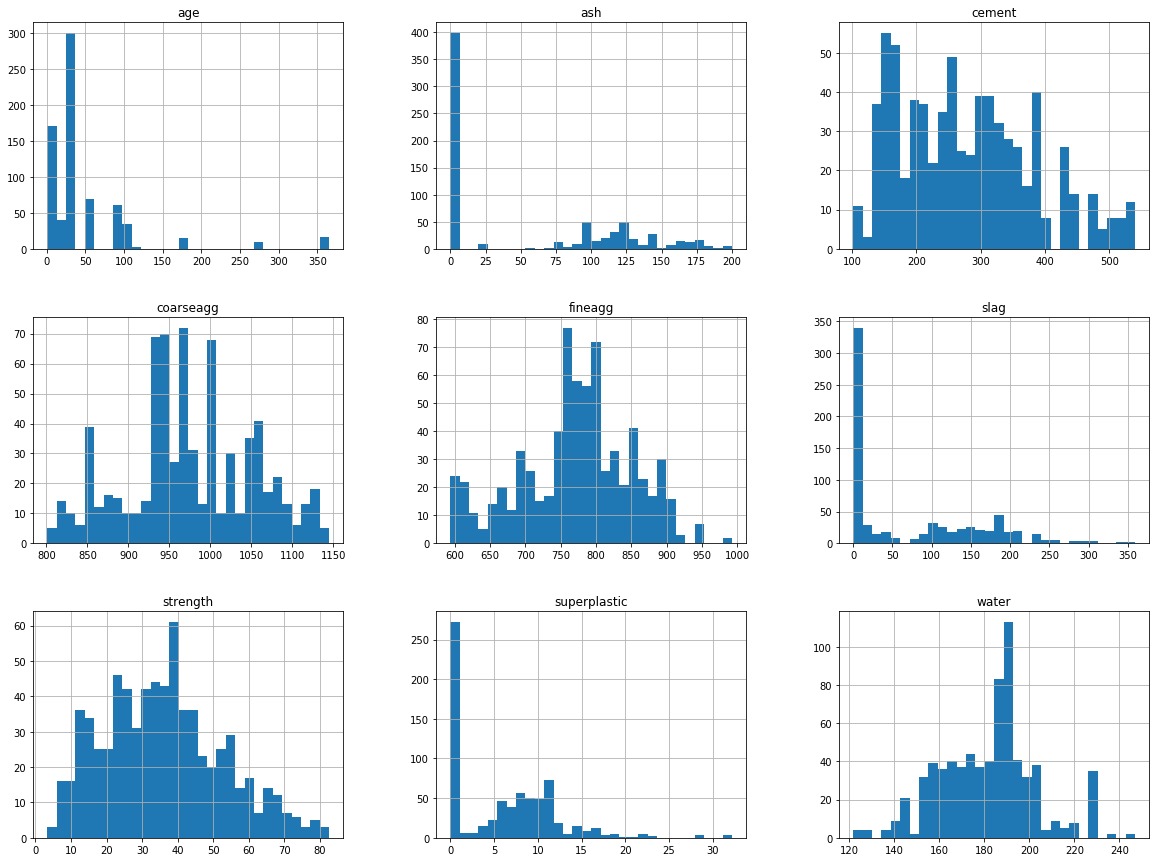

In [10]:
df_temp.hist(bins=30, figsize=(20,15))
plt.show()

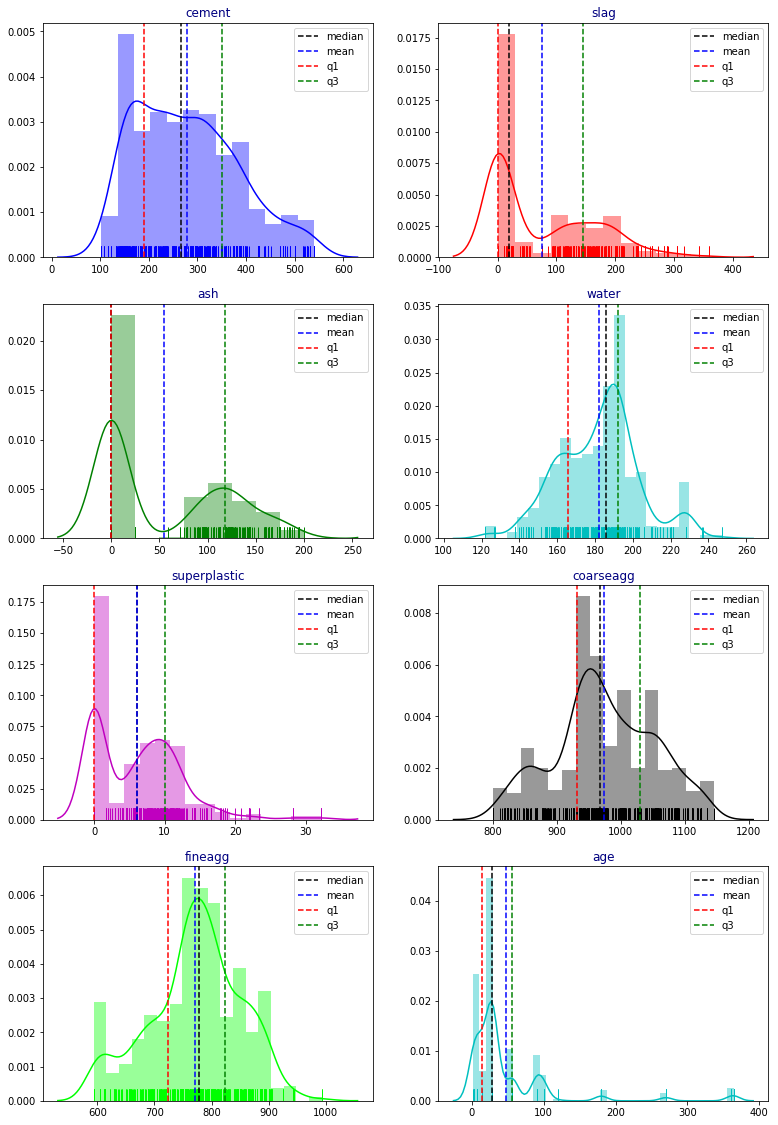

In [11]:
import itertools
cols = [i for i in df_temp.columns if i not in 'strength']
length = len(cols)
cs = ["b","r","g","c","m","k","lime","c"]
fig = plt.figure(figsize=(13,25))

for i,j,k in itertools.zip_longest(cols,range(length),cs):
    plt.subplot(5,2,j+1)
    ax = sns.distplot(df_temp[i],color=k,rug=True)
    ax.set_facecolor("w")
    quartile_1,quartile_3 = np.percentile(df[i],[25,75])
    plt.axvline(df_temp[i].median(),linestyle="dashed",label="median",color="k")
    plt.axvline(df_temp[i].mean(),linestyle="dashed",label="mean",color="b")
    plt.axvline(np.percentile(df_temp[i],25),linestyle="dashed",label="q1",color="r")
    plt.axvline(np.percentile(df_temp[i],75),linestyle="dashed",label="q3",color="g")
    plt.legend(loc="best")
    plt.title(i,color="navy")
    plt.xlabel("")

Text(0.5,0,'')

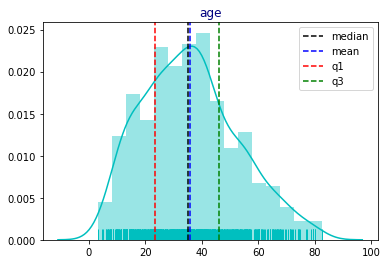

In [12]:
ax = sns.distplot(df_temp["strength"],color=k,rug=True)
ax.set_facecolor("w")
plt.axvline(df_temp["strength"].median(),linestyle="dashed",label="median",color="k")
plt.axvline(df_temp["strength"].mean(),linestyle="dashed",label="mean",color="b")
plt.axvline(np.percentile(df_temp["strength"],25),linestyle="dashed",label="q1",color="r")
plt.axvline(np.percentile(df_temp["strength"],75),linestyle="dashed",label="q3",color="g")
plt.legend(loc="best")
plt.title(i,color="navy")
plt.xlabel("")

### Observations

- Distribution of strength,cement variable is close to normal.
- However, we can see some long tails toward right for slag, water ,age and superplastic components.

### Plot strength against age

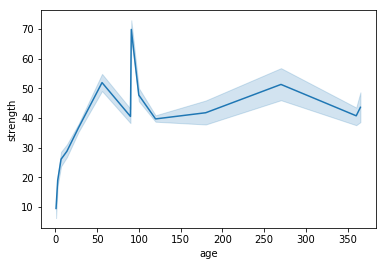

In [13]:
sns.lineplot("age","strength",data=df)

We see that with age the strength of cement increases upto a certain level, and then after 100 days there is a sharp decrease in the strength and also after 250 days there seems to be decrease in the strength,  it could be due to more moisture absorption from the atmosphere.

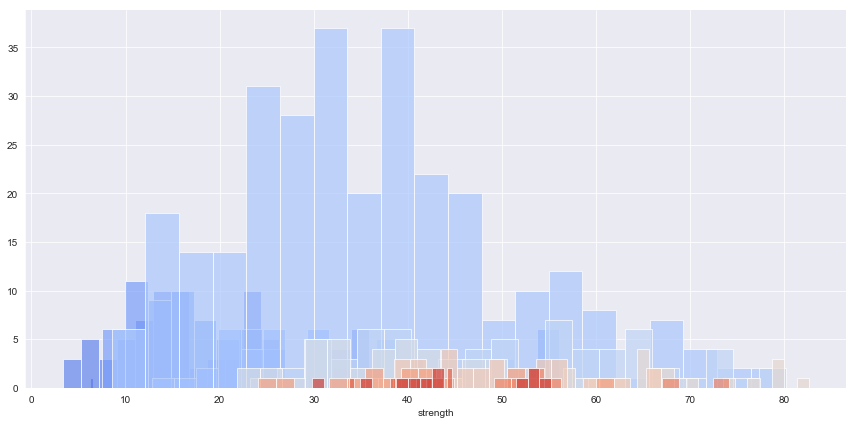

In [14]:
sns.set_style('darkgrid')
g = sns.FacetGrid(df_temp,hue="age",palette='coolwarm',size=6,aspect=2)
g = g.map(plt.hist,'strength',bins=20,alpha=0.7)

In [15]:
df_temp["age"].value_counts().sort_values()

120      2
1        2
360      6
270     10
365     11
180     15
91      19
100     35
14      40
90      42
56      70
3       80
7       89
28     300
Name: age, dtype: int64

### Box Plots to visualize the outliers

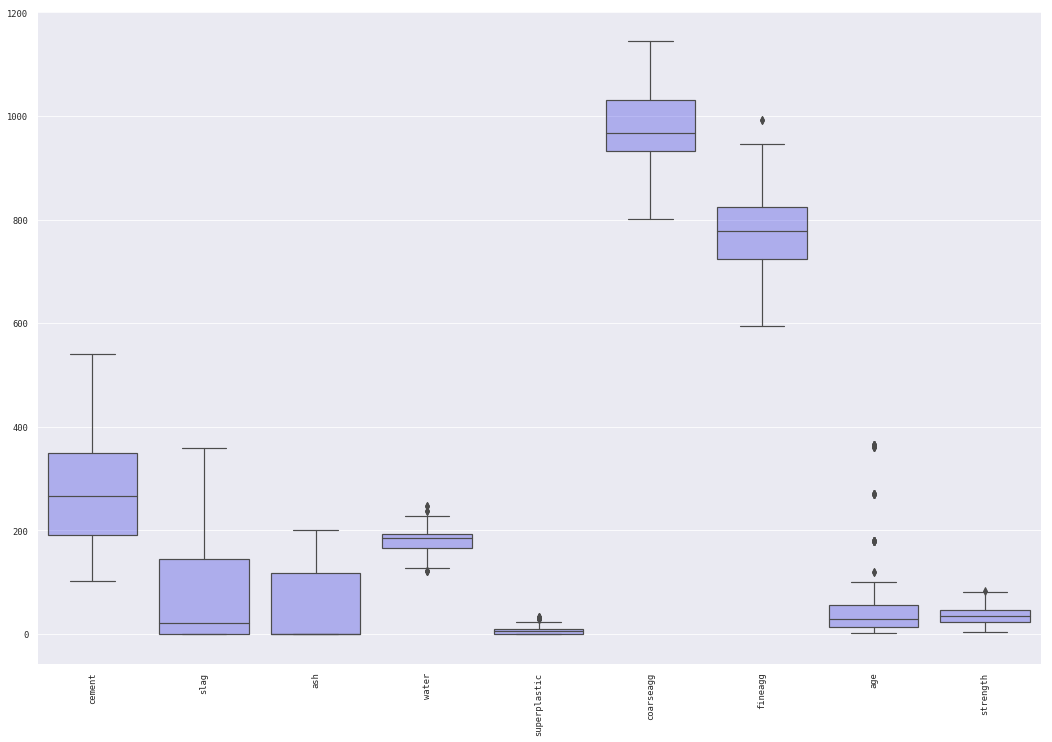

In [16]:
sns.set(context="paper", font="monospace")
# Create a figure instance
fig = plt.figure(1, figsize=(18, 12))

# Create an axes instance
ax = fig.add_subplot(111)

g = sns.boxplot(data=df_temp, ax=ax, color="blue")
g.set_xticklabels(df_temp.columns,rotation=90)

# Add transparency to colors
for patch in g.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))  

### Observations

- There are outliers within slag, age, water component. The outliers present in numeric feature can be dealt by following ways based on the domain knowledge
   -  delete the outliers (there could be loss of data due to this)
   -  impute ouliers with mean/median
   -  impute with lower and upper bound values. 

For now, we would impute the ouliers with 1% and 95% values

In [17]:
def outlier(df,columns):
    for i in columns:
        quartile_1,quartile_3 = np.percentile(df[i],[25,75])
        quartile_f,quartile_l = np.percentile(df[i],[1,95])
        IQR = quartile_3-quartile_1
        lower_bound = quartile_1 - (1.5*IQR)
        upper_bound = quartile_3 + (1.5*IQR)
        print(i,lower_bound,upper_bound,quartile_f,quartile_l)
                
        df[i].loc[df[i] < lower_bound] = quartile_f
        df[i].loc[df[i] > upper_bound] = quartile_l    
        
outlier(df_temp, ['age','fineagg','water'])

age -49.0 119.0 3.0 180.0
fineagg 574.7499999999999 973.5500000000001 594.0 891.9
water 125.99999999999999 231.60000000000002 129.4 228.0


### Bivariate Analysis using Correlation matrix and Pair plots
### Correlation Matrix

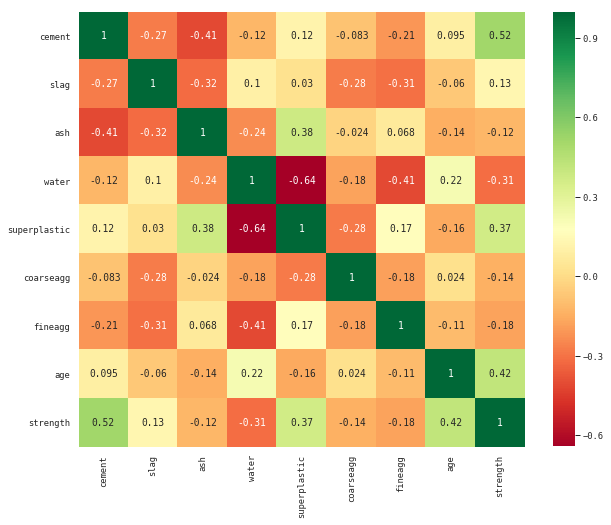

In [18]:
def correlation_matrix(df):
    corrmat = df.corr()
    top_corr_features = corrmat.index
    plt.figure(figsize=(10,8))
    #plot heat map
    g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")


correlation_matrix(df_temp)

In [19]:
# Lets check for highly correlated variables
cor= df_temp.corr()
cor.loc[:,:] = np.tril(cor,k=-1)
cor=cor.stack()
cor[(cor > 0.55) | (cor< -0.55)]

superplastic  water   -0.643203
dtype: float64

### Pair Plot

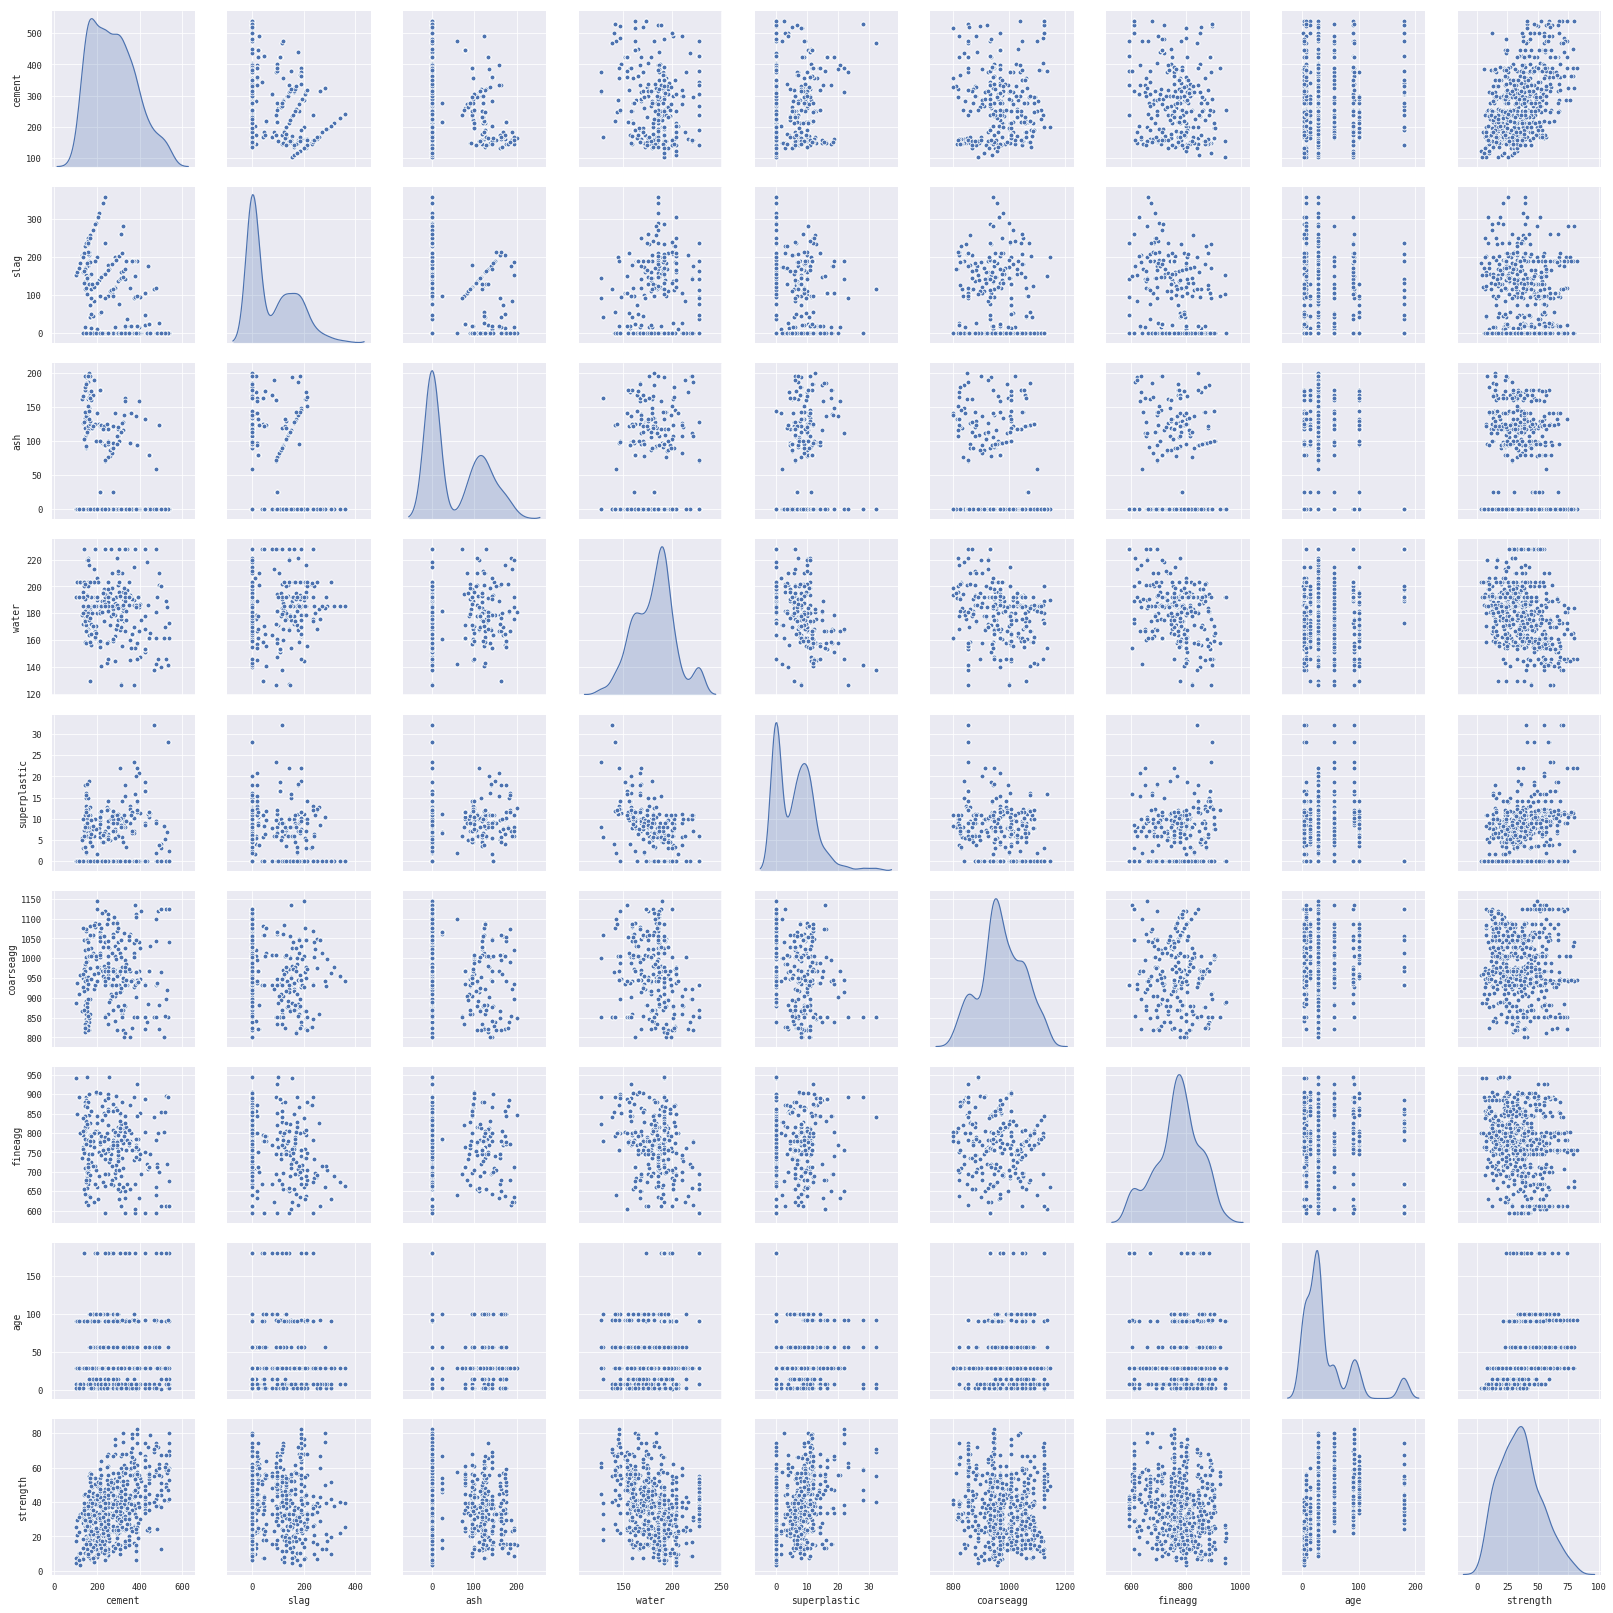

In [20]:
sns.pairplot(df_temp,diag_kind='kde')

### Observations

- We can see density plots along the diagonal, there are multiple gaussians in every parameter
    - cement parameter seems to have around 4 gaussians (3 are clearly visible and 1 is slightly visible)
    - slag parameter seems to have 2 gaussians
    - ash parameter seems to have 2 gaussians, first gaussian contains mostly zero's
    - similarly, we can see 4 gaussians for water, superplastic, coarseagg, fineagg 
    - age seems to have around 5 gaussians
    

- Cement has a good correlation with strength, the more cement stronger the concrete.
- With age, we can see that the strength of cement decreases, it could be due to more moisture absorption from the atmosphere.
- Also, we can see that higher the water, the strength of concrete decreases, its good to have lesser water
- superplasticizers has negative correlation with water, superplasticizers always help decrease water - hence an increase in strength
- Following Features are listed based on the order of importance (ascending order) to predict strength
     - cement
     - age
     - superplastic
     - water
     - fineagg
     - coarseagg
     - slag
     - ash

We will analyse these features further, to identify key features to predict stength

### Blast Furnace Slag

- Blast furnace slag powder as partial replacement of cement, from pair panel we can see that there is a negative correlation between cement and slag components i.e as the proportion of slag component increases the proportion of cement is low. 
- Also, having zero values in slag column seems to be acceptable as its a partial replacement of cement and in cases where the values are zero we can consider that slag component was not being used.

### Fly Ash
- Fly Ash, is also used in replacement of cement, from pair panel agaian we can see that there is negative correlation between cement and Fly Ash component
- Even here having zero values in Fly Ash, column seems to be acceptable as its a partial replacement of cement and in cases where the values are zero we can consider that Fly Ash component was not being used.
- Fly Ash has negative correlation with water

In [21]:
## check Blast Furnace Slag, Ash and Cement proportion

df_temp[(df_temp['slag']!=0) & (df_temp['ash']!=0)  ].head()


cement   slag    ash  water  superplastic  coarseagg  fineagg    age  \
864   213.7   98.1   24.5  181.7           6.9     1065.8    785.4  100.0   
356   136.0  162.0  126.0  172.0          10.0      923.0    764.0   28.0   
909   314.0  145.0  113.0  179.0           8.0      869.0    690.0   28.0   
551   260.0  101.0   78.0  171.0          10.0      936.0    763.0   28.0   
446   165.0  128.5  132.1  175.1           8.1     1005.8    746.6  100.0   

     strength  
864     53.90  
356     29.07  
909     46.23  
551     49.77  
446     55.02

### Superplasticizer 
- Plasticizers are also often used when Fly  ash is added to concrete to improve strength. 
- Superplasticizers always help decrease batching water thus porosity - hence an increase in strength
- Having zero values in Superplasticizers also column seems to be acceptable as its a admixture used to improve the strength of concrete and not a required component.

In [22]:
df_temp[(df_temp['ash']!=0)  &  (df_temp['superplastic']==0)]

cement  slag    ash  water  superplastic  coarseagg  fineagg    age  \
847    165.0   0.0  143.6  163.8           0.0     1005.6    900.9    3.0   
1000   165.0   0.0  143.6  163.8           0.0     1005.6    900.9  100.0   
586    165.0   0.0  143.6  163.8           0.0     1005.6    900.9   56.0   
242    165.0   0.0  143.6  163.8           0.0     1005.6    900.9   28.0   
36     165.0   0.0  143.6  163.8           0.0     1005.6    900.9   14.0   

      strength  
847      14.40  
1000     37.96  
586      36.56  
242      26.20  
36       16.88

In [23]:
## Function to train and evaluate models
def train_evaluate_model(X_train,y_train,X_test,y_test):
    classifiers = [
        Ridge(alpha=0.5),
        Lasso(alpha=0.1),
        SVR(),
        GradientBoostingRegressor(random_state=2),
        AdaBoostRegressor(random_state=2),
        RandomForestRegressor(random_state=2),
        LinearRegression(),
        xgboost.XGBRegressor(random_state=2),
        DecisionTreeRegressor(random_state=2)
    ]

    # Logging for Visual Comparison
    log_cols=["Classifier", "RMSE Train","RMSE Test", "R2 Train", "R2 Test"]
    log = pd.DataFrame(columns=log_cols)

    for clf in classifiers:
        clf.fit(X_train, y_train)
        name = clf.__class__.__name__

        y_pred_train = clf.predict(X_train)
        mse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
        r2_train = r2_score(y_train, y_pred_train)

        y_pred_test = clf.predict(X_test)
        mse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
        r2_test = r2_score(y_test, y_pred_test)

        log_entry = pd.DataFrame([[name,mse_train,mse_test,r2_train,r2_test]], columns=log_cols)

        log = log.append(log_entry)
    log.set_index(["Classifier"],inplace=True)
    
    return log.sort_values(by=['RMSE Test'])

In [24]:
initial_model_asis = train_evaluate_model(X_train,y_train,X_test,y_test)
initial_model_asis

[19:12:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RMSE Train  RMSE Test  R2 Train   R2 Test
Classifier                                                          
GradientBoostingRegressor    3.742583   5.195720  0.949697  0.903464
XGBRegressor                 3.902962   5.203390  0.945294  0.903178
RandomForestRegressor        2.528433   5.685100  0.977041  0.884422
AdaBoostRegressor            7.062768   7.458793  0.820858  0.801053
DecisionTreeRegressor        1.183336   7.782888  0.994971  0.783389
Lasso                       10.253483  10.678095  0.622436  0.592257
Ridge                       10.253454  10.679274  0.622438  0.592167
LinearRegression            10.253454  10.679277  0.622438  0.592166
SVR                         15.683336  16.557206  0.116666  0.019667

### Observation
- We see that Linear models are not giving a good performance, mainly because from the pair panel we can see that there is no linear relationship between the independent variables and the target (strength). 

#### Lets try creating polynomial Features using degree=2 and check if that boosts the performance

In [25]:
from sklearn.preprocessing import PolynomialFeatures
polynomial_features = PolynomialFeatures(degree=2)
x_poly_train = polynomial_features.fit_transform(X_train)

x_poly_test = polynomial_features.fit_transform(X_test)

model_poly = train_evaluate_model(x_poly_train,y_train,x_poly_test,y_test)
model_poly

[19:12:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RMSE Train  RMSE Test  R2 Train   R2 Test
Classifier                                                          
XGBRegressor                 3.329454   4.687164  0.960190  0.921437
GradientBoostingRegressor    3.236069   4.828773  0.962392  0.916618
RandomForestRegressor        2.562804   5.596279  0.976413  0.888005
AdaBoostRegressor            6.212038   6.925869  0.861415  0.828467
DecisionTreeRegressor        1.183336   7.388302  0.994971  0.804796
LinearRegression             7.138750   7.777580  0.816983  0.783684
Ridge                        7.152420   7.793956  0.816281  0.782772
Lasso                        7.330082   7.947327  0.807041  0.774139
SVR                         15.810526  16.673139  0.102280  0.005891

### Observation:
- With polynomial of degree 2 we see that there is a boost in performance for Linear models
- SVR is performing very poorly. So we will exclude SVR this model from further steps

### Feature Selection Using Random Forest

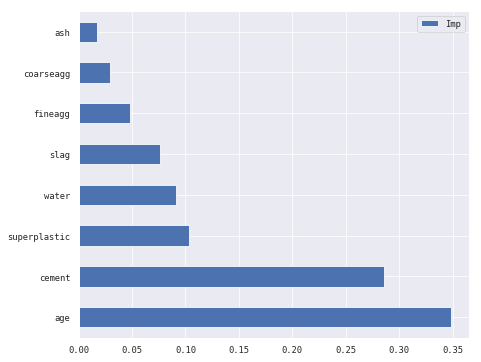

In [26]:
fs_model = RandomForestRegressor(n_estimators=100,oob_score=True,random_state=42)
fs_model.fit(X_train, y_train)
fs_model.feature_importances_


pd.DataFrame(fs_model.feature_importances_, columns = ["Imp"], index = X_train.columns).sort_values(['Imp'],ascending=False).plot(kind='barh',figsize=[7,6])

### Feature Selection Using DecisionTreeRegressor

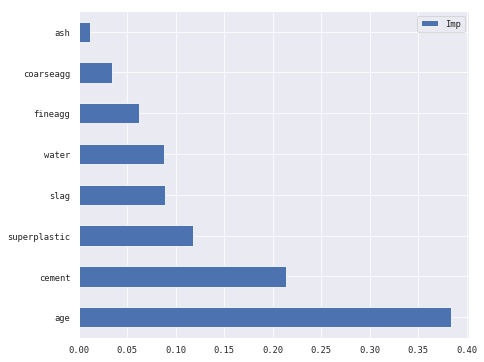

In [27]:
fs_model_dt = DecisionTreeRegressor(random_state=42)
fs_model_dt.fit(X_train, y_train)
fs_model_dt.feature_importances_

pd.DataFrame(fs_model_dt.feature_importances_, columns = ["Imp"], index = X_train.columns).sort_values(['Imp'],ascending=False).plot(kind='barh',figsize=[7,6])

### Inference

- With both RandomForestRegressor and DecisionTreeRegressor, we see that cement, age, superplastic, slag and water are the key features

## Feature Engineering

A key factor in concrete strength is the water-cement ratio, so lets create a new feature names "water_cement_ratio"

In [28]:
df_temp["water_cement_ratio"] = df_temp["water"]/df_temp["cement"]

Next, we would create "coarse_fine_agg_ratio" using Coarse and Fine aggregate components 

In [29]:
df_temp["coarse_fine_agg_ratio"] = df_temp["coarseagg"]/df_temp["fineagg"]

With a bit of ground work around the domain , I also found that water_binder_ratio is another factor which could help in predicting the cement strength. So, lets create a new feature - 'water_binder_ratio'.

In [30]:
df_temp["water_binder_ratio"] = df_temp["water"]/(df_temp["cement"] + df_temp["ash"] + df_temp["slag"])

In [31]:
df_temp.head()

cement   slag    ash  water  superplastic  coarseagg  fineagg    age  \
907   285.0  190.0    0.0  163.0           7.6     1031.0    685.0   28.0   
864   213.7   98.1   24.5  181.7           6.9     1065.8    785.4  100.0   
629   322.2    0.0  115.6  196.0          10.4      817.9    813.4   28.0   
910   331.0    0.0    0.0  192.0           0.0      879.0    825.0    3.0   
356   136.0  162.0  126.0  172.0          10.0      923.0    764.0   28.0   

     strength  water_cement_ratio  coarse_fine_agg_ratio  water_binder_ratio  
907     53.58            0.571930               1.505109            0.343158  
864     53.90            0.850257               1.357016            0.540291  
629     31.18            0.608318               1.005532            0.447693  
910     13.52            0.580060               1.065455            0.580060  
356     29.07            1.264706               1.208115            0.405660

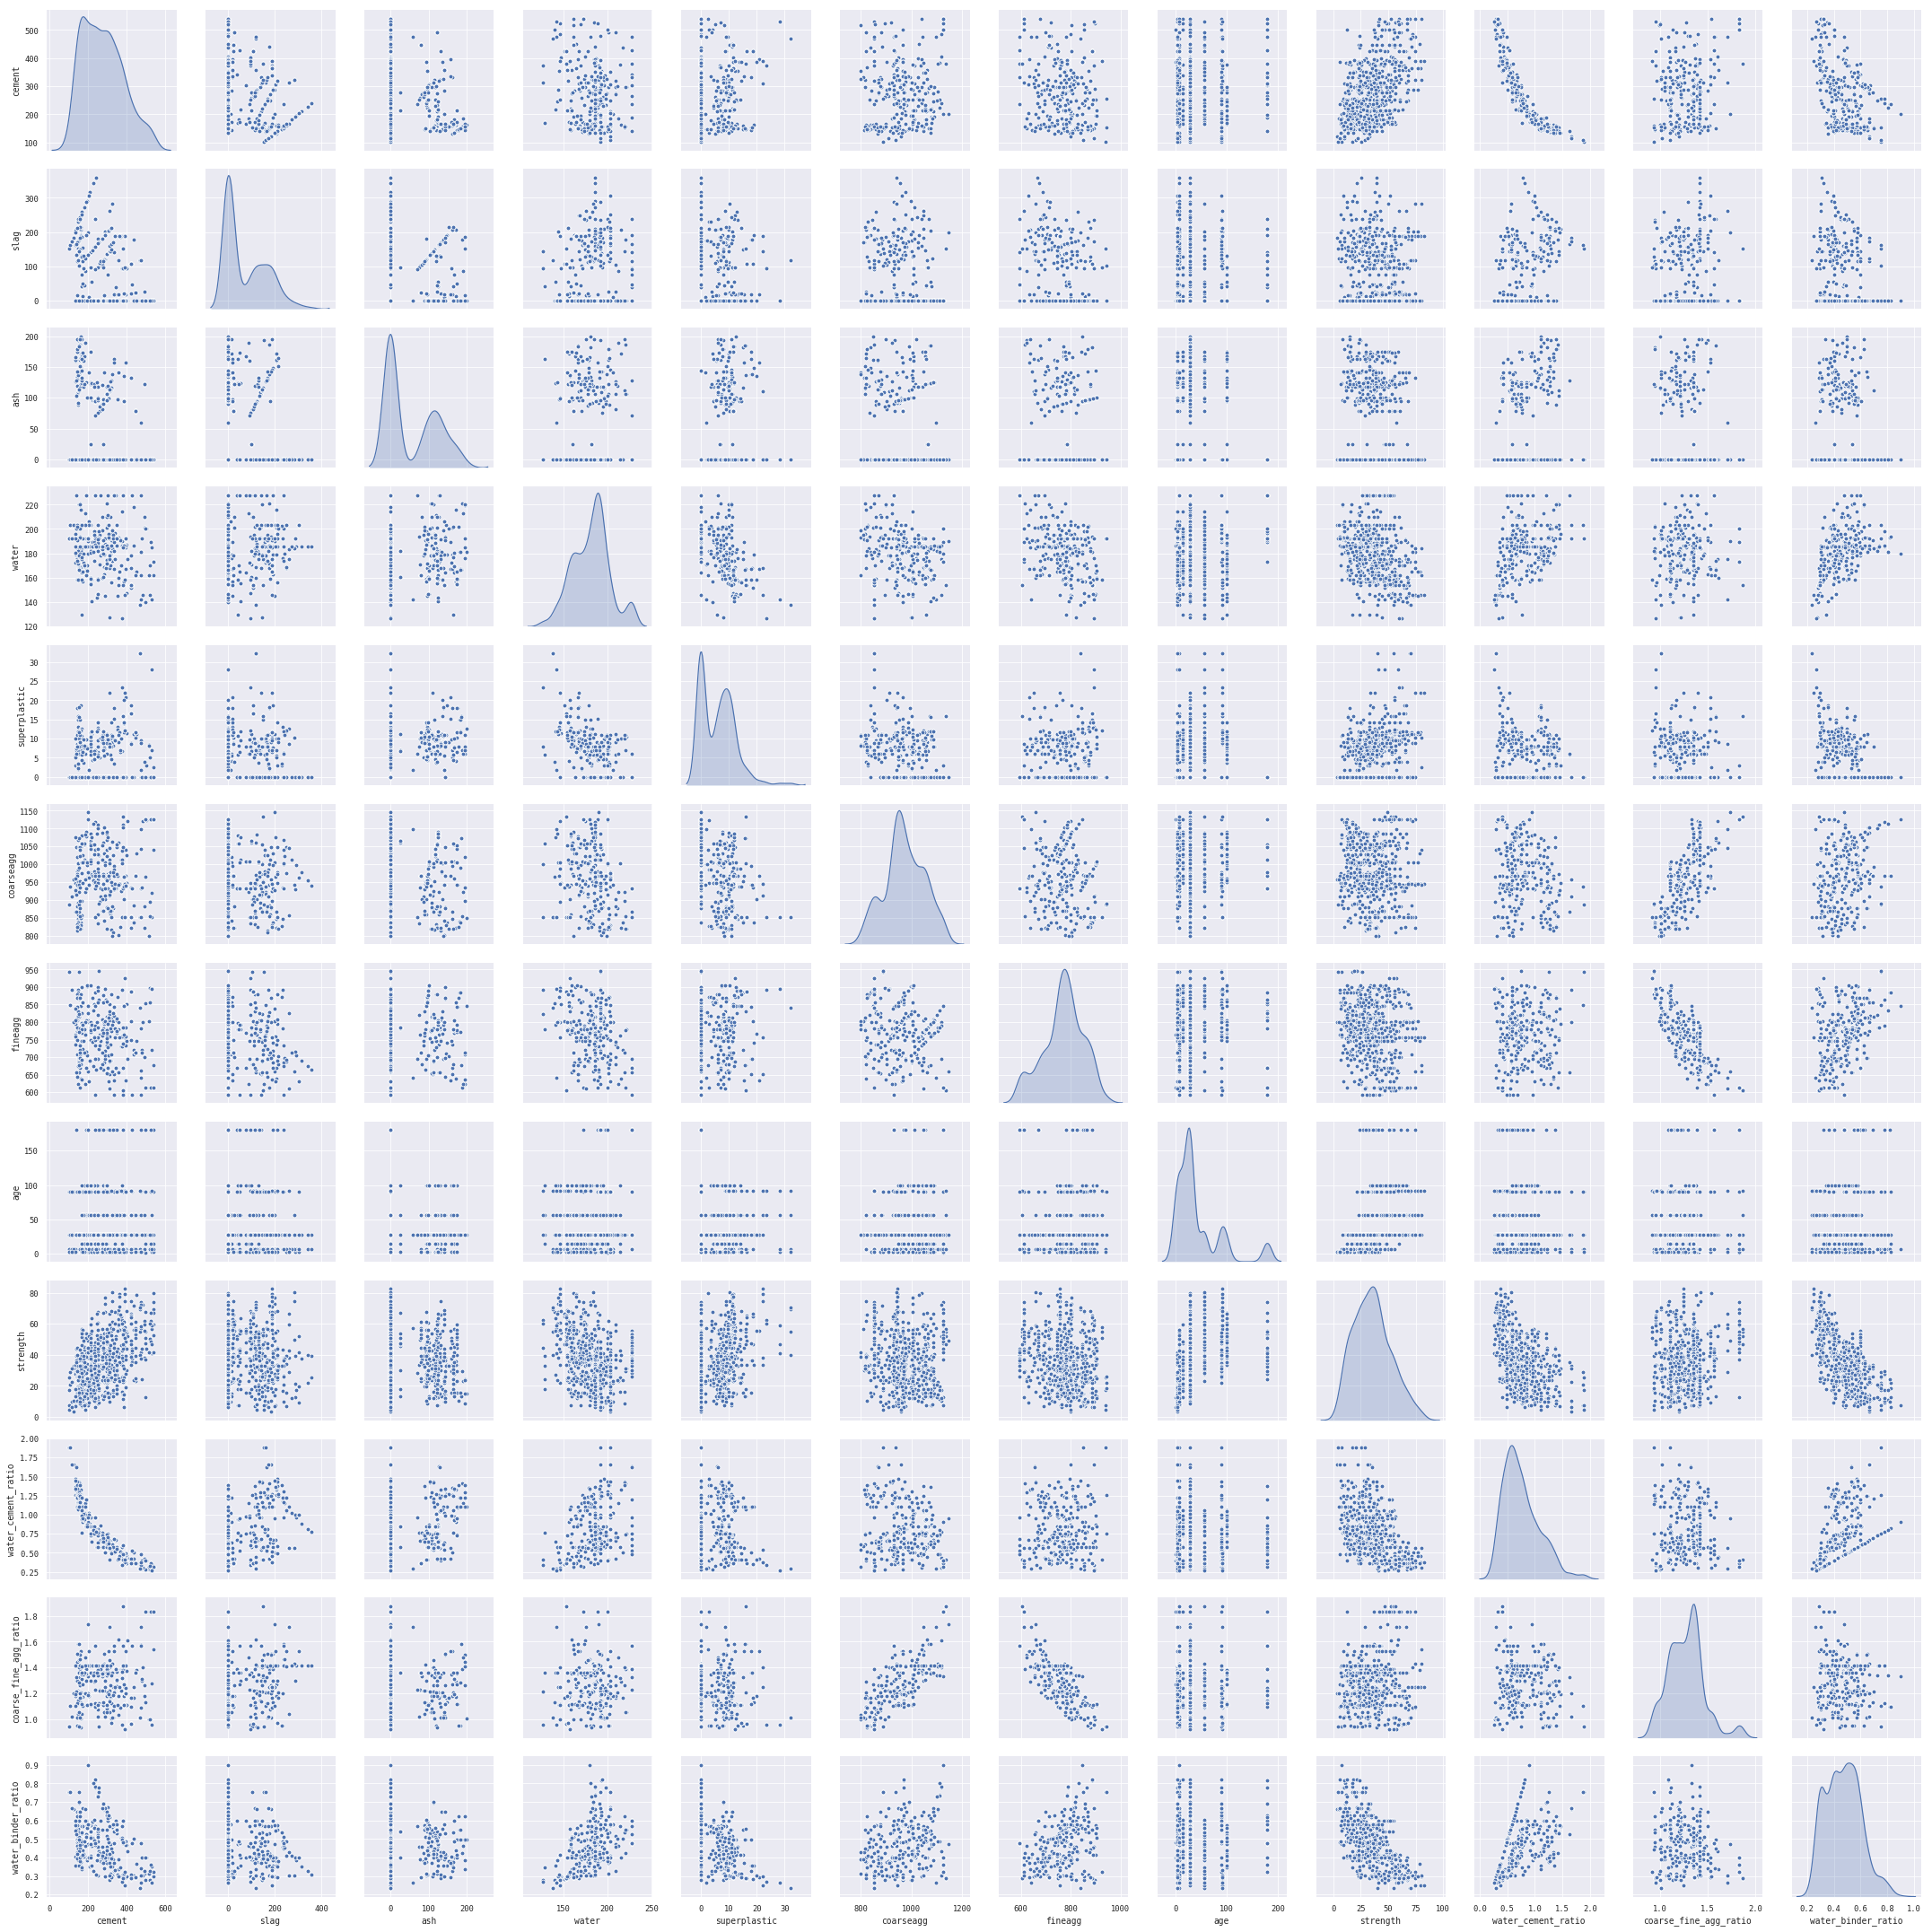

In [32]:
sns.pairplot(df_temp,diag_kind='kde')

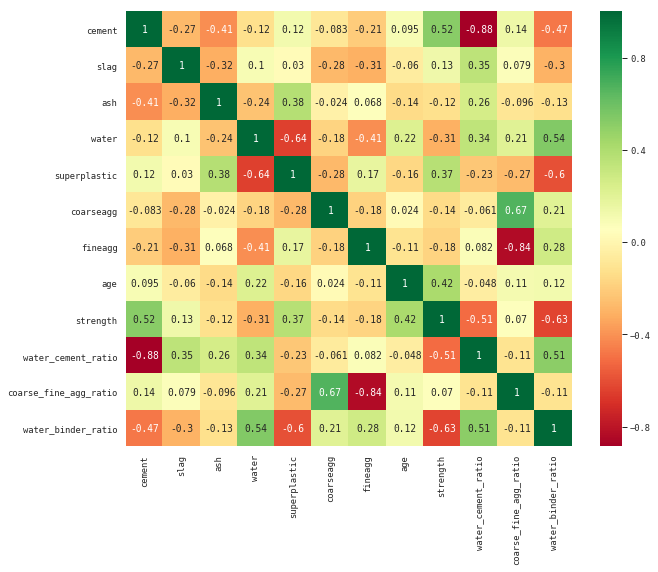

In [33]:
correlation_matrix(df_temp)

#### We see a lot of correlation with the composite features and the base features using which they are derived. So. lets drop cement, water , coarseagg ,  fineagg , ash, slag columns as we have derived new features out of these

In [34]:
# #Drop a column
df_temp.drop('cement', axis=1, inplace=True)
df_temp.drop('water', axis=1, inplace=True)

In [35]:

df_temp.drop('coarseagg', axis=1, inplace=True)
df_temp.drop('fineagg', axis=1, inplace=True)

In [36]:
df_temp.drop('ash', axis=1, inplace=True)
df_temp.drop('slag', axis=1, inplace=True)

In [37]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 721 entries, 907 to 721
Data columns (total 6 columns):
superplastic             721 non-null float64
age                      721 non-null float64
strength                 721 non-null float64
water_cement_ratio       721 non-null float64
coarse_fine_agg_ratio    721 non-null float64
water_binder_ratio       721 non-null float64
dtypes: float64(6)
memory usage: 59.4 KB


### Lets get pre- process the test data to create the new features

In [38]:
df_temp_test = X_test.copy()
df_temp_test["water_cement_ratio"] = df_temp_test["water"]/df_temp_test["cement"]
df_temp_test ["coarse_fine_agg_ratio"] = df_temp_test ["coarseagg"]/df_temp_test ["fineagg"]
df_temp_test["water_binder_ratio"] = df_temp_test["water"]/(df_temp_test["cement"] + df_temp_test["ash"] + df_temp_test["slag"])

# #Drop a column
df_temp_test.drop('cement', axis=1, inplace=True)
df_temp_test.drop('water', axis=1, inplace=True)
df_temp_test.drop('coarseagg', axis=1, inplace=True)
df_temp_test.drop('fineagg', axis=1, inplace=True)
df_temp_test.drop('ash', axis=1, inplace=True)
df_temp_test.drop('slag', axis=1, inplace=True)

### Build a Model with the composite features created using feature engineering

In [39]:
target = 'strength'
X_train = df_temp.loc[:, df_temp.columns!=target]
y_train = df_temp.loc[:, df_temp.columns==target]

X_test = df_temp_test.loc[:, df_temp_test.columns!=target]

fe_model1 = train_evaluate_model(X_train,y_train,X_test,y_test)

fe_model1

[19:12:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RMSE Train  RMSE Test  R2 Train   R2 Test
Classifier                                                          
XGBRegressor                 4.060722   5.114453  0.940782  0.906460
GradientBoostingRegressor    3.931313   5.132596  0.944496  0.905795
RandomForestRegressor        2.573662   5.341333  0.976212  0.897977
AdaBoostRegressor            6.933924   6.928696  0.827334  0.828327
DecisionTreeRegressor        1.210579   7.070416  0.994737  0.821232
LinearRegression             9.512257  10.916463  0.675051  0.573849
Ridge                        9.526853  10.959822  0.674053  0.570457
Lasso                        9.592576  11.052483  0.669540  0.563163
SVR                         12.467489  12.386998  0.441779  0.451304

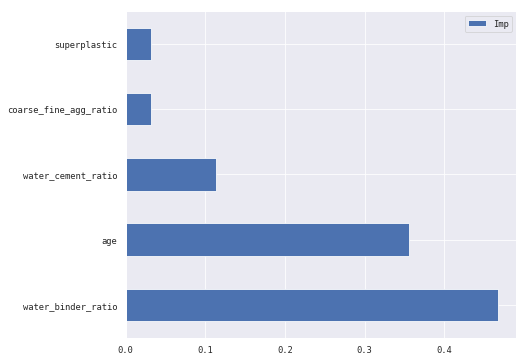

In [40]:
fs_model = RandomForestRegressor(n_estimators=100,oob_score=True,random_state=42)
fs_model.fit(X_train, y_train)
fs_model.feature_importances_


pd.DataFrame(fs_model.feature_importances_, columns = ["Imp"], index = X_train.columns).sort_values(['Imp'],ascending=False).plot(kind='barh',figsize=[7,6])

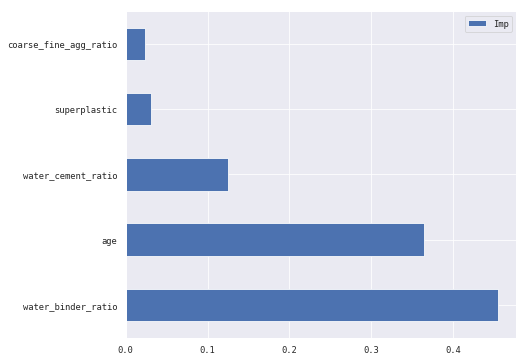

In [41]:
fs_model_dt = DecisionTreeRegressor(random_state=42)
fs_model_dt.fit(X_train, y_train)
fs_model_dt.feature_importances_

pd.DataFrame(fs_model_dt.feature_importances_, columns = ["Imp"], index = X_train.columns).sort_values(['Imp'],ascending=False).plot(kind='barh',figsize=[7,6])

### Lets check if quadratic features can help improve the model

In [42]:
from sklearn.preprocessing import PolynomialFeatures
polynomial_features = PolynomialFeatures(degree=2)
x_poly_train = polynomial_features.fit_transform(X_train)

x_poly_test = polynomial_features.fit_transform(X_test)

fe_model_poly = train_evaluate_model(x_poly_train,y_train,x_poly_test,y_test)
fe_model_poly

[19:12:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RMSE Train  RMSE Test  R2 Train   R2 Test
Classifier                                                          
GradientBoostingRegressor    3.598725   5.247852  0.953490  0.901517
XGBRegressor                 3.755970   5.275274  0.949337  0.900485
RandomForestRegressor        2.602591   5.664029  0.975675  0.885277
DecisionTreeRegressor        1.210579   6.935390  0.994737  0.827995
AdaBoostRegressor            6.604548   7.075141  0.843349  0.820993
LinearRegression             7.343030  14.289117  0.806358  0.269853
SVR                         13.915801  14.332271  0.304552  0.265436
Ridge                        7.409076  14.456720  0.802859  0.252624
Lasso                        7.630299  14.841639  0.790911  0.212296

### Observation
- Linear models are not giving good performance, even with polynomial features of degree 2 for the compposite features. So, we will not consider Linear models.
- Decision Tree, RandomForest and Adaboost seems to be highly overfitting the data. 

### Let us explore the data for any clusters as there appears to be multiple gaussians in the independent features

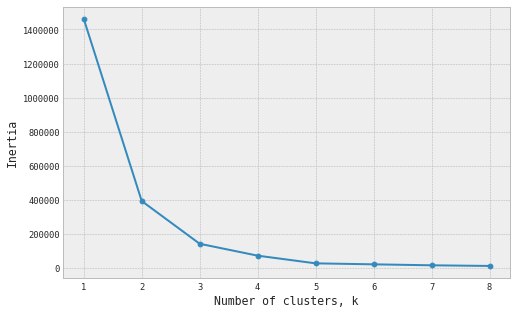

In [43]:
from sklearn.cluster import KMeans

#check the optimal k value
ks = range(1, 9)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(df_temp.drop('strength',axis=1))
    inertias.append(model.inertia_)

plt.figure(figsize=(8,5))
plt.style.use('bmh')
plt.plot(ks, inertias, '-o')
plt.xlabel('Number of clusters, k')
plt.ylabel('Inertia')
plt.xticks(ks)
plt.show()

In [44]:
from scipy.stats import zscore
# df_std = df_temp.drop(['strength'],axis=1).apply(zscore)
df_std = df_temp.apply(zscore)

In [45]:
kmeans = KMeans(n_clusters=3,random_state=4)
kmeans.fit(df_std)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=4, tol=0.0001, verbose=0)

In [46]:
# Check the number of data in each cluster

labels = kmeans.labels_
counts = np.bincount(labels[labels>=0])
print(counts)

[103 227 391]


In [47]:
df_std.columns

Index(['superplastic', 'age', 'strength', 'water_cement_ratio',
       'coarse_fine_agg_ratio', 'water_binder_ratio'],
      dtype='object')

In [48]:
# Distribution looks fine.

# let us check the centers in each group
centroids = kmeans.cluster_centers_
centroid_df = pd.DataFrame(centroids, columns = list(df_temp))
centroid_df.transpose()

0         1         2
superplastic          -0.742115  0.893720 -0.323367
age                    1.968070 -0.151869 -0.430273
strength               0.487739  0.926046 -0.666112
water_cement_ratio    -0.046373 -0.822992  0.490015
coarse_fine_agg_ratio  0.490020 -0.197640 -0.014342
water_binder_ratio     0.453217 -1.038539  0.483547

In [49]:
predictions = kmeans.predict(df_std)
predictions
df_std["group"] = predictions
df_std['group'] = df_std['group'].astype('category')
df_std.dtypes

superplastic              float64
age                       float64
strength                  float64
water_cement_ratio        float64
coarse_fine_agg_ratio     float64
water_binder_ratio        float64
group                    category
dtype: object

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000016013A00A90>,
      dtype=object)

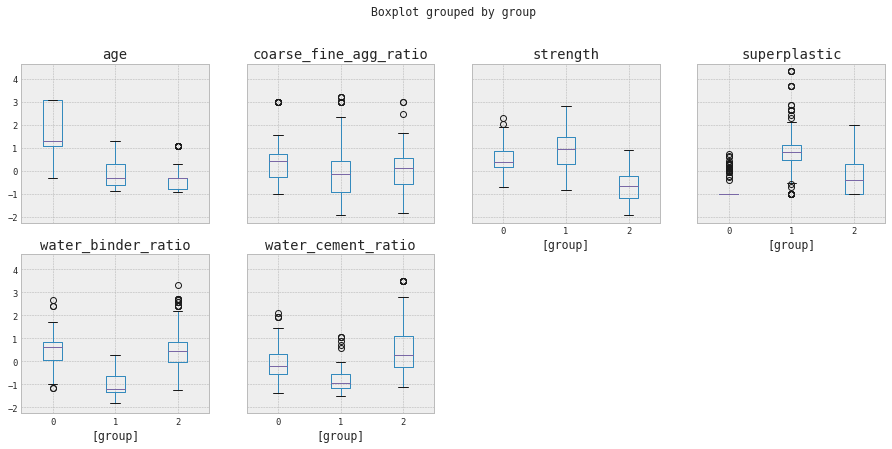

In [50]:
# Visualize the centers

df_std.boxplot(by = 'group',  layout=(3,4), figsize=(15, 10))

In [51]:
# Addressing outliers at group level       
def replace(group):
    median, std = group.median(), group.std()  #Get the median and the standard deviation of every group 
    outliers = (group - median).abs() > 2*std # Subtract median from every member of each group. Take absolute values > 2std
    group[outliers] = group.median()       
    return group

data_corrected = (df_std.groupby('group').transform(replace)) 
concat_data = data_corrected.join(pd.DataFrame(df_std['group']))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000160154CBD30>,
      dtype=object)

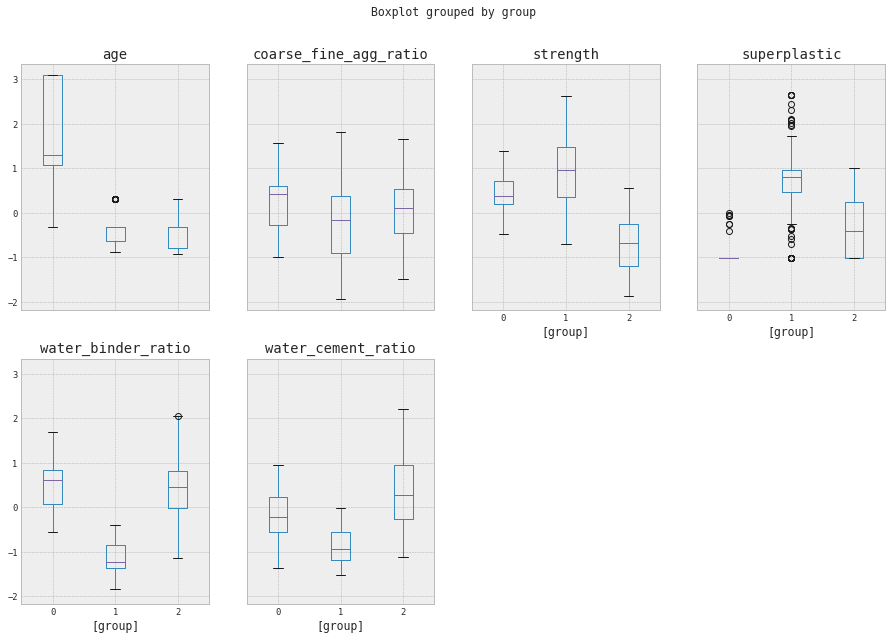

In [52]:
concat_data.boxplot(by = 'group', layout=(2,4), figsize=(15, 10))

Note: When we remove outliers and replace with median or mean, the distribution shape changes, the standard deviation becomes tighter creating new outliers. The new outliers would be much closer to the centre than original outliers so we accept them without modifying them

### No distinct clusters seems to be visible, lets explore further.

In [53]:
df_group0=df_std[(df_std['group']==0)]
df_group1=df_std[(df_std['group']==1)]
df_group2=df_std[(df_std['group']==2)]

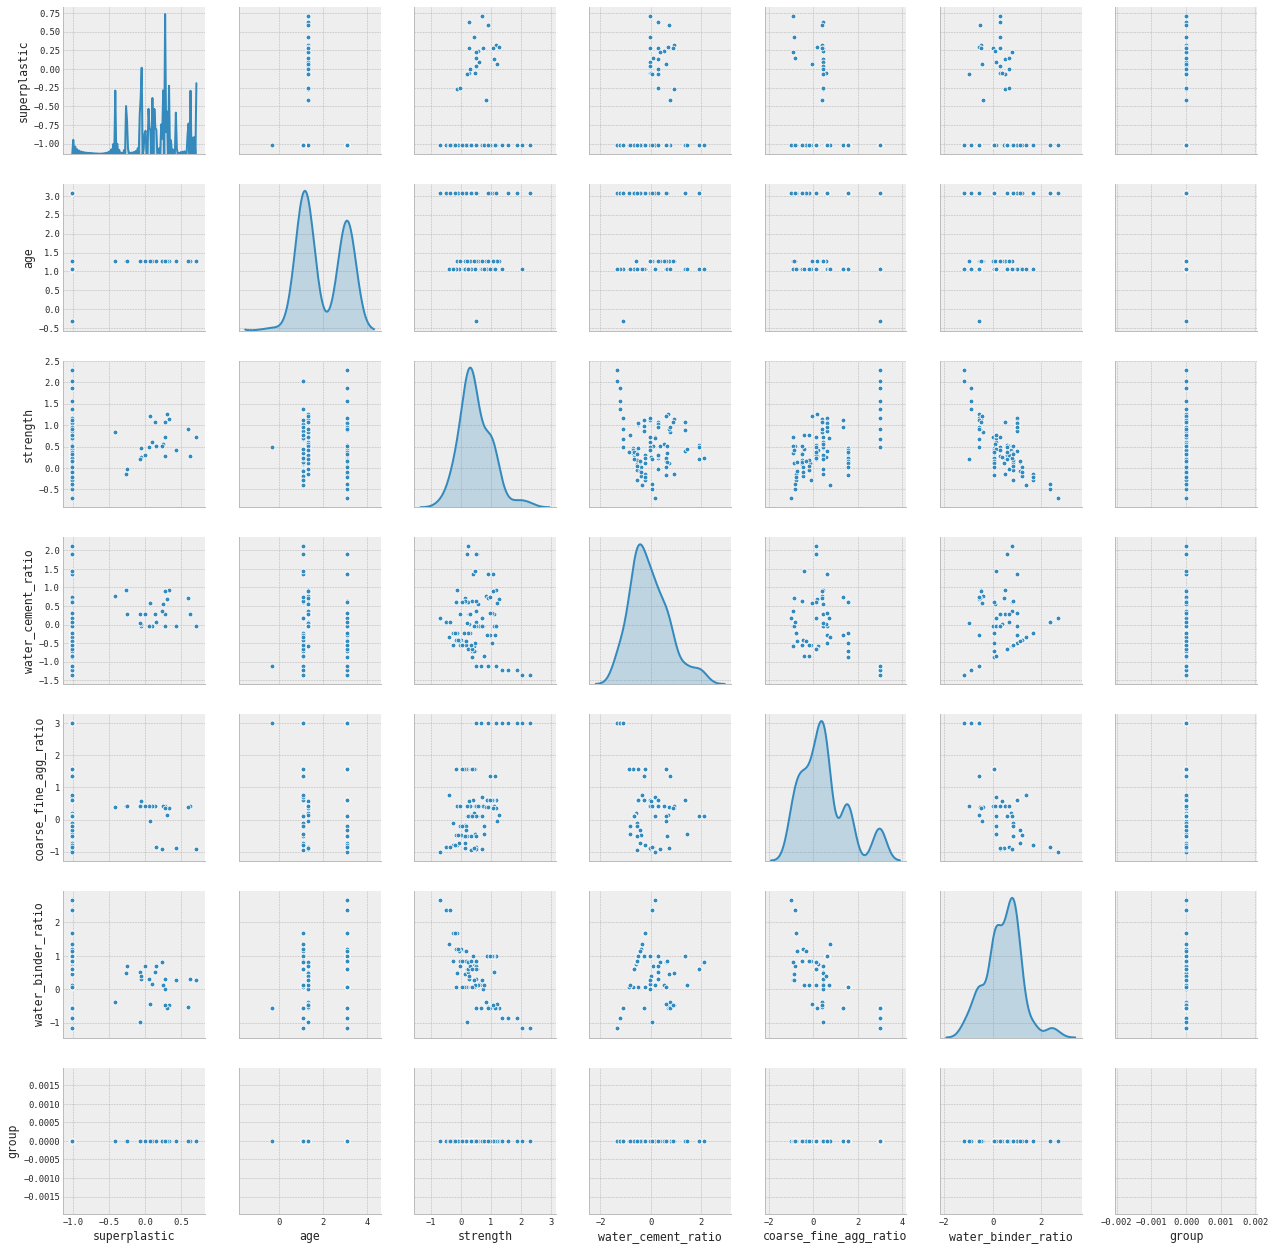

In [54]:
sns.pairplot(df_group0,diag_kind='kde')

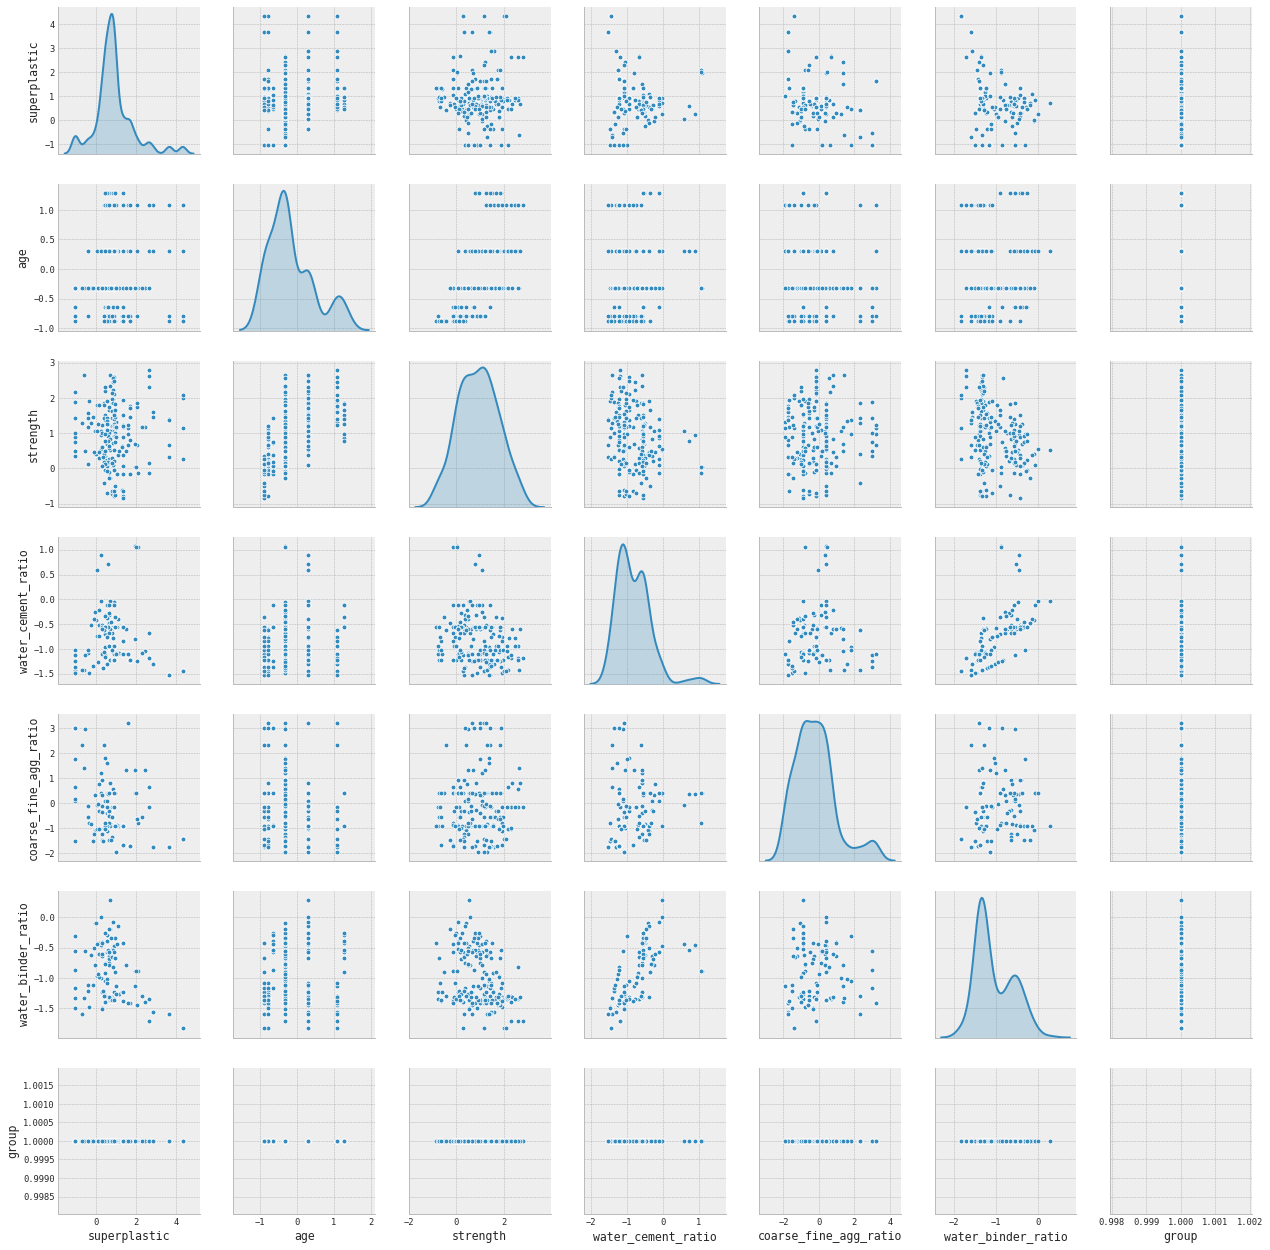

In [55]:
sns.pairplot(df_group1,diag_kind='kde')

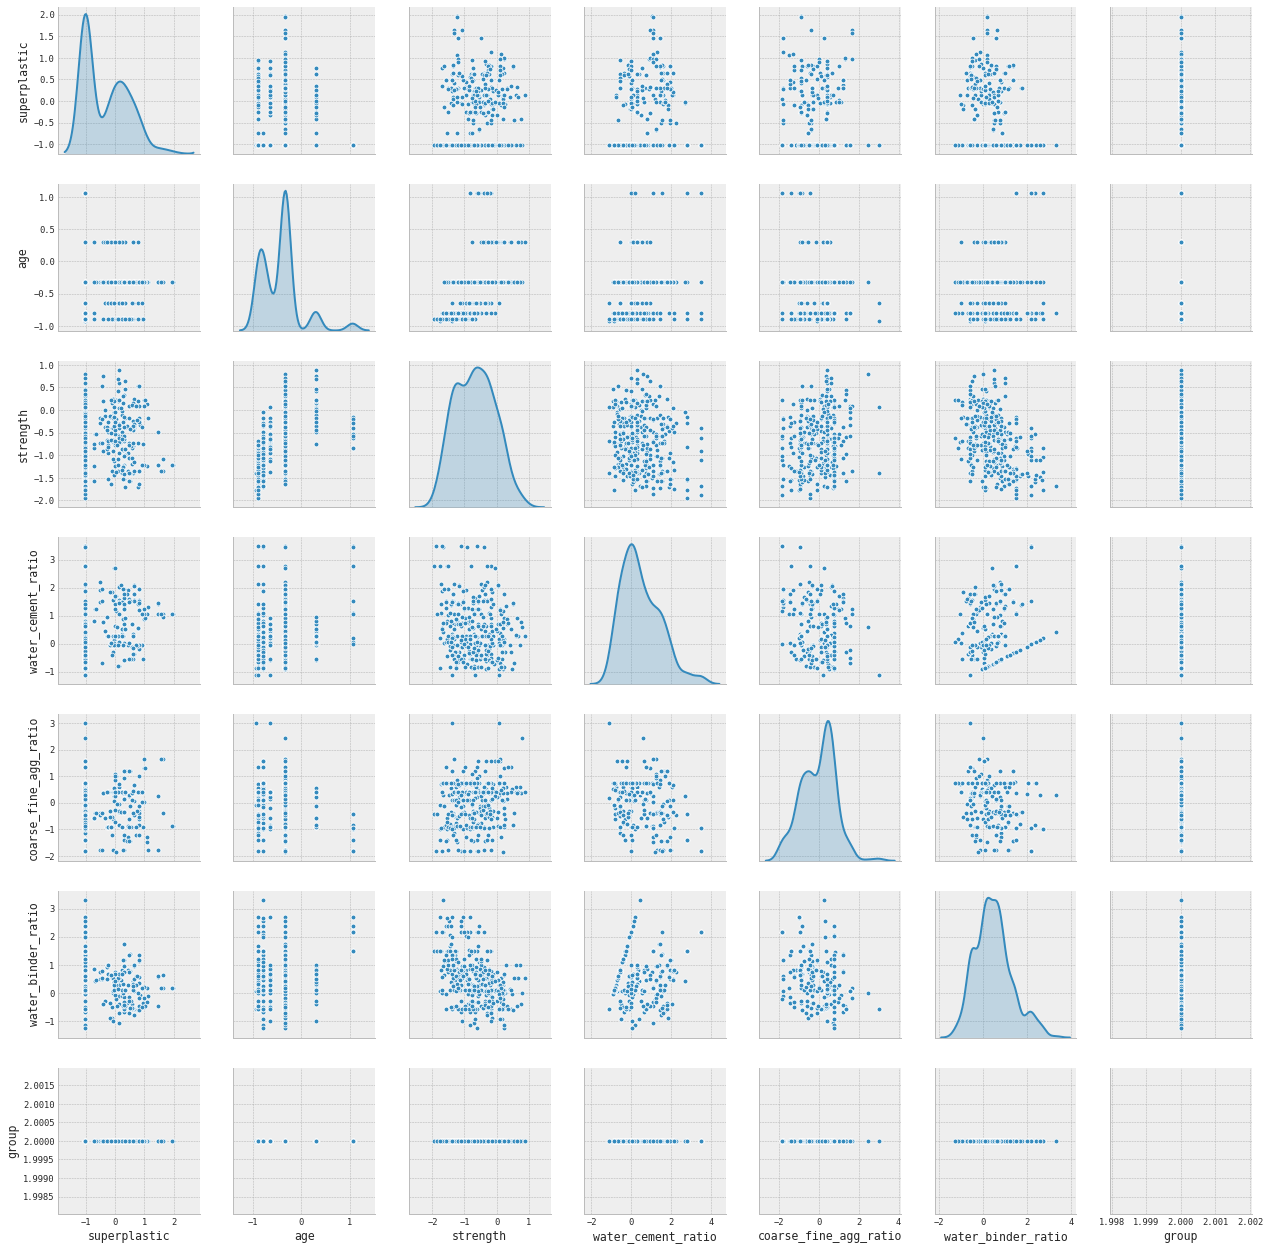

In [56]:
sns.pairplot(df_group2,diag_kind='kde')

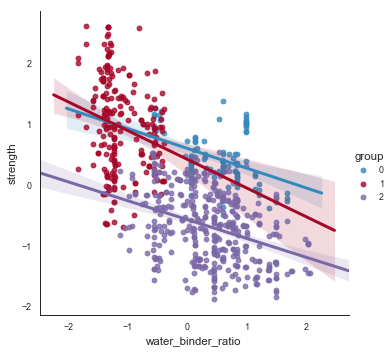

In [57]:
# ash vs strength

var = 'water_binder_ratio'

with sns.axes_style("white"):
    plot = sns.lmplot(var,'strength',data=concat_data,hue='group')
#plot.set(ylim = (-3,3))

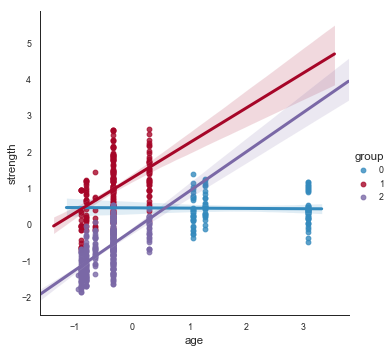

In [58]:
# age vs strength
var = 'age'

with sns.axes_style("white"):
    plot = sns.lmplot(var,'strength',data=concat_data,hue='group')

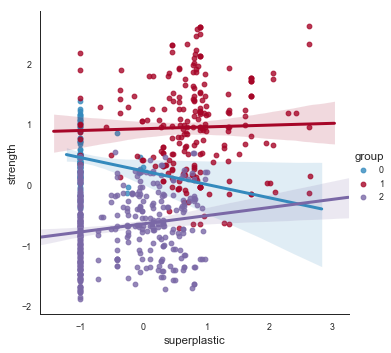

In [59]:
# superplastic vs strength
var = 'superplastic'

with sns.axes_style("white"):
    plot = sns.lmplot(var,'strength',data=concat_data,hue='group')

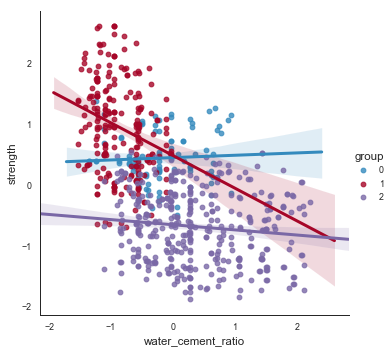

In [60]:
# water_cement_ratio vs strength
var = 'water_cement_ratio'

with sns.axes_style("white"):
    plot = sns.lmplot(var,'strength',data=concat_data,hue='group')

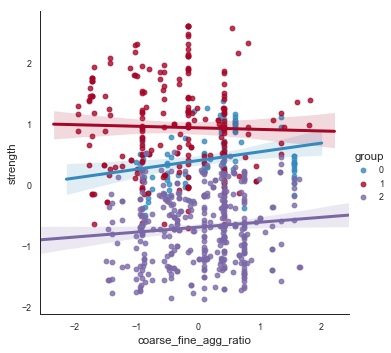

In [61]:
# coarse_fine_agg_ratio vs strength
var = 'coarse_fine_agg_ratio'

with sns.axes_style("white"):
    plot = sns.lmplot(var,'strength',data=concat_data,hue='group')

### Observation

There don't seem to be a clear seperation of clusters among features. It seems to be unlikely to get better results by splitting the data into clusters.

### Lets tune GradientBoost and Xgboost models further to get a better performance



Set the range of hyperparameters to be tuned with RandonSearch for GradientBoost.
Hyperparameters are the parameters that are initialized before training a model because they cannot be learned from the algorithm. They control the behavior of the training algorithm and have a high impact on the performance of a model.


In [62]:
from sklearn.model_selection import RandomizedSearchCV
import pprint

#Hyperparameters are the parameters that are initialized before training a model 
#because they cannot be learned from the algorithm. They control the behavior of the training algorithm 
#and have a high impact on the performance of a model

learning_rate = [0.01, 0.5, 0.1,1]
# Number of trees in GradientBoost
n_estimators = [int(x) for x in np.linspace(start = 100 , stop = 1000, num = 4)]   # returns evenly spaced 10 numbers

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(3, 10, num = 4)]  # returns evenly spaced numbers can be changed to any
max_depth.append(None)

#the fraction of observations to be used in individual tree
subsample = [0.8,0.9,1]

# Minimum number of samples required to split a node
min_samples_split = [0.5, 1.0, 2, 5, 8, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]


# Create the random grid
rs_param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'learning_rate':learning_rate,
                'subsample':subsample}

pprint.pprint(rs_param_grid)

{'learning_rate': [0.01, 0.5, 0.1, 1],
 'max_depth': [3, 5, 7, 10, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [0.5, 1.0, 2, 5, 8, 10],
 'n_estimators': [100, 400, 700, 1000],
 'subsample': [0.8, 0.9, 1]}


### Tune GBM using randomisedsearchcv

In [63]:
gbr_clf = GradientBoostingRegressor(random_state=2)
rf_random = RandomizedSearchCV(estimator=gbr_clf, param_distributions=rs_param_grid,
                              n_iter = 10, scoring='neg_mean_squared_error', 
                              cv = 5, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)

# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.2min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=GradientBoostingRegressor(alpha=0.9,
                                                       criterion='friedman_mse',
                                                       init=None,
                                                       learning_rate=0.1,
                                                       loss='ls', max_depth=3,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                            

In [64]:
rf_random.best_params_

{'subsample': 0.9,
 'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 3,
 'learning_rate': 0.1}

#### Evaluate the score of GBM by RandomisedSearchCV

In [65]:
best_random = rf_random.best_estimator_

best_random.score(X_test , y_test)

0.9232710755331391

Set the hyperparameters in the range closer to the one output by RandomizedSearchCV, to tune using GrinSearchCV

In [66]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'subsample': [0.8,0.85,0.9,0.95,1],
     'n_estimators': [800,900,1000,1200],
     'min_samples_split': [2,4,6],
     'min_samples_leaf': [2],
     'max_features': ['auto','sqrt'],
     'max_depth': [3,5],
     'learning_rate': [0.15, 0.1,0.05,0.01]
}    

### Tune the GBM model using GridSearchCV

In [67]:
grid_search = GridSearchCV(estimator = gbr_clf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2, return_train_score=True,scoring='neg_mean_squared_error')

In [68]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train);

Fitting 5 folds for each of 960 candidates, totalling 4800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   39.4s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 13.4min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 17.4min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 21.7min
[Parallel(n_jobs=-1)]: Done 4800 out of 4800 | elapsed: 26.9min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will c

In [69]:
grid_search.best_params_

{'learning_rate': 0.05,
 'max_depth': 3,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 1200,
 'subsample': 1}

#### Evaluate the score for GridSerachCV

In [70]:
best_grid = grid_search.best_estimator_
best_score = best_grid.score(X_test, y_test)
best_score

0.924390023043305

In [71]:
best_grid

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.05, loss='ls', max_depth=3,
                          max_features='sqrt', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=2, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=1200,
                          n_iter_no_change=None, presort='auto', random_state=2,
                          subsample=1, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False)

Save the model to a file, for later use.

In [72]:
import pickle
filename = 'concrete_model.sav'
pickle.dump(best_grid,open(filename,'wb'))

## Let's try to tune Xgboost parameter and see if we get better performance than GBM

In [73]:
xgb_model = xgboost.XGBRegressor(learning_rate=0.01,  
                      colsample_bytree = 1,
                      subsample = 0.8,
                      objective='reg:squarederror', 
                      n_estimators=1000, 
                      max_depth=3, 
                      gamma=1)

In [74]:
eval_set = [(X_train, y_train), (X_test, y_test)]
%time xgb_model.fit(X_train, y_train, eval_metric='rmse', eval_set=eval_set, verbose=True)
evals_result = xgb_model.evals_result()

[0]	validation_0-rmse:38.7193	validation_1-rmse:38.6715
[1]	validation_0-rmse:38.3571	validation_1-rmse:38.313
[2]	validation_0-rmse:38.0009	validation_1-rmse:37.9691
[3]	validation_0-rmse:37.6448	validation_1-rmse:37.6191
[4]	validation_0-rmse:37.2935	validation_1-rmse:37.2792
[5]	validation_0-rmse:36.9479	validation_1-rmse:36.9404
[6]	validation_0-rmse:36.604	validation_1-rmse:36.6025
[7]	validation_0-rmse:36.2626	validation_1-rmse:36.2703
[8]	validation_0-rmse:35.9269	validation_1-rmse:35.9427
[9]	validation_0-rmse:35.5937	validation_1-rmse:35.6146
[10]	validation_0-rmse:35.2657	validation_1-rmse:35.3023
[11]	validation_0-rmse:34.941	validation_1-rmse:34.987
[12]	validation_0-rmse:34.6214	validation_1-rmse:34.6795
[13]	validation_0-rmse:34.3034	validation_1-rmse:34.3672
[14]	validation_0-rmse:33.9896	validation_1-rmse:34.0689
[15]	validation_0-rmse:33.6742	validation_1-rmse:33.7593
[16]	validation_0-rmse:33.3695	validation_1-rmse:33.4665
[17]	validation_0-rmse:33.0633	validation_1-r

[144]	validation_0-rmse:11.6033	validation_1-rmse:11.9823
[145]	validation_0-rmse:11.5215	validation_1-rmse:11.8991
[146]	validation_0-rmse:11.4436	validation_1-rmse:11.8218
[147]	validation_0-rmse:11.3675	validation_1-rmse:11.7433
[148]	validation_0-rmse:11.2939	validation_1-rmse:11.6692
[149]	validation_0-rmse:11.2216	validation_1-rmse:11.5981
[150]	validation_0-rmse:11.148	validation_1-rmse:11.5252
[151]	validation_0-rmse:11.0736	validation_1-rmse:11.4504
[152]	validation_0-rmse:11.0009	validation_1-rmse:11.3741
[153]	validation_0-rmse:10.9309	validation_1-rmse:11.3037
[154]	validation_0-rmse:10.8624	validation_1-rmse:11.2335
[155]	validation_0-rmse:10.7921	validation_1-rmse:11.1602
[156]	validation_0-rmse:10.7254	validation_1-rmse:11.0918
[157]	validation_0-rmse:10.6573	validation_1-rmse:11.0205
[158]	validation_0-rmse:10.5908	validation_1-rmse:10.9514
[159]	validation_0-rmse:10.5239	validation_1-rmse:10.8824
[160]	validation_0-rmse:10.4598	validation_1-rmse:10.8188
[161]	validatio

[286]	validation_0-rmse:6.3246	validation_1-rmse:6.56877
[287]	validation_0-rmse:6.31171	validation_1-rmse:6.55711
[288]	validation_0-rmse:6.29931	validation_1-rmse:6.54415
[289]	validation_0-rmse:6.28545	validation_1-rmse:6.52982
[290]	validation_0-rmse:6.27091	validation_1-rmse:6.51321
[291]	validation_0-rmse:6.2578	validation_1-rmse:6.50082
[292]	validation_0-rmse:6.24479	validation_1-rmse:6.48766
[293]	validation_0-rmse:6.2331	validation_1-rmse:6.47567
[294]	validation_0-rmse:6.22185	validation_1-rmse:6.46447
[295]	validation_0-rmse:6.20859	validation_1-rmse:6.4514
[296]	validation_0-rmse:6.19642	validation_1-rmse:6.43875
[297]	validation_0-rmse:6.18307	validation_1-rmse:6.42461
[298]	validation_0-rmse:6.17004	validation_1-rmse:6.41032
[299]	validation_0-rmse:6.15984	validation_1-rmse:6.39912
[300]	validation_0-rmse:6.14776	validation_1-rmse:6.38811
[301]	validation_0-rmse:6.13479	validation_1-rmse:6.3732
[302]	validation_0-rmse:6.12397	validation_1-rmse:6.36277
[303]	validation_0-

[428]	validation_0-rmse:5.22046	validation_1-rmse:5.53482
[429]	validation_0-rmse:5.21646	validation_1-rmse:5.53164
[430]	validation_0-rmse:5.21353	validation_1-rmse:5.5298
[431]	validation_0-rmse:5.21118	validation_1-rmse:5.52682
[432]	validation_0-rmse:5.20724	validation_1-rmse:5.52219
[433]	validation_0-rmse:5.20266	validation_1-rmse:5.51847
[434]	validation_0-rmse:5.19857	validation_1-rmse:5.51545
[435]	validation_0-rmse:5.19388	validation_1-rmse:5.51095
[436]	validation_0-rmse:5.18978	validation_1-rmse:5.50817
[437]	validation_0-rmse:5.18423	validation_1-rmse:5.50363
[438]	validation_0-rmse:5.17859	validation_1-rmse:5.50059
[439]	validation_0-rmse:5.1756	validation_1-rmse:5.49761
[440]	validation_0-rmse:5.17263	validation_1-rmse:5.49309
[441]	validation_0-rmse:5.16756	validation_1-rmse:5.48965
[442]	validation_0-rmse:5.16287	validation_1-rmse:5.48574
[443]	validation_0-rmse:5.15993	validation_1-rmse:5.48402
[444]	validation_0-rmse:5.15759	validation_1-rmse:5.48277
[445]	validation

[570]	validation_0-rmse:4.73286	validation_1-rmse:5.2226
[571]	validation_0-rmse:4.72974	validation_1-rmse:5.22111
[572]	validation_0-rmse:4.72745	validation_1-rmse:5.22002
[573]	validation_0-rmse:4.72544	validation_1-rmse:5.2191
[574]	validation_0-rmse:4.72149	validation_1-rmse:5.21676
[575]	validation_0-rmse:4.71767	validation_1-rmse:5.21474
[576]	validation_0-rmse:4.71308	validation_1-rmse:5.21266
[577]	validation_0-rmse:4.70917	validation_1-rmse:5.21107
[578]	validation_0-rmse:4.70657	validation_1-rmse:5.20877
[579]	validation_0-rmse:4.70488	validation_1-rmse:5.2079
[580]	validation_0-rmse:4.70183	validation_1-rmse:5.20699
[581]	validation_0-rmse:4.7002	validation_1-rmse:5.20715
[582]	validation_0-rmse:4.69568	validation_1-rmse:5.20543
[583]	validation_0-rmse:4.69289	validation_1-rmse:5.20406
[584]	validation_0-rmse:4.69015	validation_1-rmse:5.20218
[585]	validation_0-rmse:4.6867	validation_1-rmse:5.20152
[586]	validation_0-rmse:4.68306	validation_1-rmse:5.20013
[587]	validation_0-

[712]	validation_0-rmse:4.39313	validation_1-rmse:5.10523
[713]	validation_0-rmse:4.39166	validation_1-rmse:5.10615
[714]	validation_0-rmse:4.39022	validation_1-rmse:5.10637
[715]	validation_0-rmse:4.3884	validation_1-rmse:5.10656
[716]	validation_0-rmse:4.38619	validation_1-rmse:5.10703
[717]	validation_0-rmse:4.38313	validation_1-rmse:5.10674
[718]	validation_0-rmse:4.37941	validation_1-rmse:5.10548
[719]	validation_0-rmse:4.3766	validation_1-rmse:5.10491
[720]	validation_0-rmse:4.37462	validation_1-rmse:5.10422
[721]	validation_0-rmse:4.37084	validation_1-rmse:5.10292
[722]	validation_0-rmse:4.36757	validation_1-rmse:5.10243
[723]	validation_0-rmse:4.36573	validation_1-rmse:5.10241
[724]	validation_0-rmse:4.36384	validation_1-rmse:5.10154
[725]	validation_0-rmse:4.36157	validation_1-rmse:5.10068
[726]	validation_0-rmse:4.35835	validation_1-rmse:5.09845
[727]	validation_0-rmse:4.35576	validation_1-rmse:5.09656
[728]	validation_0-rmse:4.35282	validation_1-rmse:5.09584
[729]	validation

[854]	validation_0-rmse:4.10394	validation_1-rmse:5.0493
[855]	validation_0-rmse:4.1029	validation_1-rmse:5.04841
[856]	validation_0-rmse:4.10174	validation_1-rmse:5.0493
[857]	validation_0-rmse:4.09997	validation_1-rmse:5.0478
[858]	validation_0-rmse:4.09904	validation_1-rmse:5.04829
[859]	validation_0-rmse:4.09771	validation_1-rmse:5.04873
[860]	validation_0-rmse:4.09609	validation_1-rmse:5.04886
[861]	validation_0-rmse:4.09525	validation_1-rmse:5.04824
[862]	validation_0-rmse:4.09438	validation_1-rmse:5.04788
[863]	validation_0-rmse:4.09377	validation_1-rmse:5.04774
[864]	validation_0-rmse:4.09254	validation_1-rmse:5.04861
[865]	validation_0-rmse:4.09121	validation_1-rmse:5.04909
[866]	validation_0-rmse:4.09006	validation_1-rmse:5.04943
[867]	validation_0-rmse:4.08857	validation_1-rmse:5.04997
[868]	validation_0-rmse:4.08693	validation_1-rmse:5.04991
[869]	validation_0-rmse:4.08564	validation_1-rmse:5.04942
[870]	validation_0-rmse:4.0836	validation_1-rmse:5.04896
[871]	validation_0-

[996]	validation_0-rmse:3.87074	validation_1-rmse:5.00473
[997]	validation_0-rmse:3.86892	validation_1-rmse:5.00397
[998]	validation_0-rmse:3.86695	validation_1-rmse:5.00212
[999]	validation_0-rmse:3.86631	validation_1-rmse:5.0024
Wall time: 2.9 s


### RandomizedSearchCV to tune XGB parameters

In [75]:
learning_rate = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ]
# Number of trees in GradientBoost
n_estimators = [int(x) for x in np.linspace(start = 100 , stop = 1000, num = 4)]   # returns evenly spaced 10 numbers

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(3, 10, num = 6)]  # returns evenly spaced numbers can be changed to any

#the fraction of observations to be used in individual tree
subsample = [0.8,0.9,1]

colsample_bytree = [0.8,0.9,1]

gamma = [0.0, 0.1, 0.2 , 0.3, 0.4, 1, 5, 10]

objective=['reg:squarederror']
#
#reg_alpha = [0.3,0.4,0.5]


# Create the random grid
rs_param_grid_xgb = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'subsample': subsample,
               'colsample_bytree': colsample_bytree,
               'gamma': gamma,
               'learning_rate':learning_rate,
               'objective':objective
                }

pprint.pprint(rs_param_grid_xgb)


{'colsample_bytree': [0.8, 0.9, 1],
 'gamma': [0.0, 0.1, 0.2, 0.3, 0.4, 1, 5, 10],
 'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
 'max_depth': [3, 4, 5, 7, 8, 10],
 'n_estimators': [100, 400, 700, 1000],
 'objective': ['reg:squarederror'],
 'subsample': [0.8, 0.9, 1]}


In [76]:
rf_random_xgb = RandomizedSearchCV(estimator=xgb_model, param_distributions=rs_param_grid_xgb,
                              n_iter = 10, scoring='neg_mean_squared_error', 
                              cv = 5, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)

# Fit the random search model
rf_random_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   25.6s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=1,
                                          importance_type='gain',
                                          learning_rate=0.01, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=1000,
                                          n_jobs=1, nthread=None,
                                          objective='reg:squarederror',
                                          r...
                   param_distributions={'colsample_bytree': [0.8, 0.9, 1],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4, 1, 5,
                                 

In [77]:
rf_random_xgb.best_params_

{'subsample': 0.9,
 'objective': 'reg:squarederror',
 'n_estimators': 700,
 'max_depth': 3,
 'learning_rate': 0.05,
 'gamma': 0.4,
 'colsample_bytree': 0.9}

In [78]:
best_random_xgb = rf_random_xgb.best_estimator_

best_random_xgb.score(X_test , y_test)

0.9175261760068948

### GridSearch using XGB

In [79]:
param_grid_xgb = {
     'colsample_bytree': [0.8, 0.9, 1],
     'subsample': [0.8,0.9,1],
     'n_estimators': [600,800,1000],
     'max_depth': [3, 5, 7, 10],
     'gamma': [0, 1],
     'learning_rate': [0.01, 0.05, 0.1],
     #'reg_alpha': [0.3, 0.4, 0.5],
     'objective': ['reg:squarederror']
}    

In [80]:
grid_search_xgb = GridSearchCV(estimator = xgb_model, param_grid = param_grid_xgb, 
                          cv = 5, n_jobs = -1, verbose = 2, return_train_score=True,scoring='neg_mean_squared_error')

In [81]:
# Fit the grid search to the data
grid_search_xgb.fit(X_train, y_train);

Fitting 5 folds for each of 648 candidates, totalling 3240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 17.9min
[Parallel(n_jobs=-1)]: Done 3240 out of 3240 | elapsed: 22.9min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [82]:
grid_search_xgb.best_params_

{'colsample_bytree': 0.8,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_depth': 3,
 'n_estimators': 800,
 'objective': 'reg:squarederror',
 'subsample': 0.9}

In [83]:
best_grid_xgb = grid_search_xgb.best_estimator_
best_score_xgb = best_grid_xgb.score(X_test, y_test)
best_score_xgb

0.9227246409167946

### GradientBoost and XGBoost are giving the same performance, i.e around 92% of accuracy score. Lets use Bootstraping technique to give the confidence interval of the model

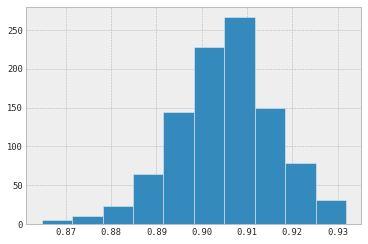

95.0 confidence interval 88.2% and 92.6%


In [85]:
from sklearn.utils import resample
import pickle
filename = 'concrete_model.sav'

load_lr_model=pickle.load(open(filename,'rb'))


df_train = X_train.join(y_train)
df_test = X_test.join(y_test)
df_row_merged = pd.concat([df_train, df_test], ignore_index=True)
values = df_row_merged.values
#values = df_test.values

# configure bootstrap
n_iterations = 1000
n_size = int(len(X_train) * 1)


# run bootstrap
stats = list()
for i in range(n_iterations):
    # prepare train and test sets
    train = resample(values, n_samples=n_size)
    test = np.array([x for x in values if x.tolist() not in train.tolist()])
    # fit model
    model = load_lr_model
    model.fit(train[:,:-1], train[:,-1])
    y_test_array = test[:,-1]
    # evaluate model
    predictions = model.predict(test[:,:-1])
    score = model.score(test[:, :-1] , y_test_array)
    stats.append(score)

# plot scores
plt.hist(stats)
plt.show()

# confidence intervals
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(stats, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(stats, p))
print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))

### Conclusion

- We were given a dataset to predict the concrete compressive strength, given the independent features - cement, water, fly ash, slag, superplastic , age. 
- We found that this is a regression problem and choose RMSE as the  metric to evaluate the performance of the model
- Then we performed univariate, bivariate analysis to understand the data and found that not all the variables were highly correlated with the target.
- There were few outliers within slag, age, water component, we imputed the ouliers with 1% and 95% values
- Then, created composite features - 
   -  water_cement_ratio
   -  coarse_fine_agg_ratio
    - water_binder_ratio
    
- We observered a lot of correlation with the composite features and the base features using which they are derived. So. lets drop cement, water , coarseagg , fineagg , ash, slag columns as we have derived new features out of these

- We also explored the data for any clusters as there appeared to be multiple gaussians in the independent features. We split the data into 3 clusters using KMean clustering. However,  no distinct clusters seemed to be visible with the avaiable features.

- Then we trained the model using various algorithms and evalutaed the performance of the model 
     - Linear models were not giving good performance, even with polynomial features of degree 2 for the compposite features.So, we did not consider Linear models.
    - Decision Tree, RandomForest and Adaboost seemed to be highly overfitting the data. 
    - We considered GradientBoost and XGBoost for further tuning
    
- We tuned the hyperparameters for GradientBoost and XGBoost using RandomizedSearch and GridSearch, found that both were giving similar performance.

### At 95% confidence interval our model performs between - 88.2 % and 92.6%
 